# Multivariate Linear Regression in Python with Numpy

Welcome to one more tutorial! In the last post (see <a href="/20180809linearRegressionScratch/#more">here</a>) we saw how to do a linear regression on Python using barely no library but native functions (except for visualization).

In this exercise, we will see how to implement a linear regression with multiple inputs using Numpy. We will also use the Gradient Descent algorithm to train our model.

The first step is to import all the necessary libraries. The ones we will use are:
- Numpy - for numerical calculations;
- Pandas - to read csv and data processing;
- Matplotlib - for visualization

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Now import the data that we want to work on. This data (hypothetical) consists in the following information from real state properties:
- Size (the size of the housing in square meters);
- Nr Bedrooms ->  the number of bedrooms;
- Nr Bathrooms -> the number of bathrooms
- Price -> The price of the house, in terms of thousands of dollars (or any other currency since the data is hypothetical)

**Hypothesis**
The price is linearly correlated with the size, nr of bedrooms and nr of bathrooms of a housing.

We will check validity of the above hypothesis through linear regression.

 Pandas function `read_csv()` is used to read the csv file 'housingprices.csv' and place it as a dataframe.

In [3]:
df= pd.read_csv('housingprices.csv')
df.head()

,Size,Nr Bedrooms,Nr Bathrooms,Price
0,84,1,1,43.747
1,45,4,1,30.100
2,73,1,3,39.481
3,34,2,3,23.908
4,31,4,3,24.144


In [4]:
print(df.columns)

Index(['Size', 'Nr Bedrooms', 'Nr Bathrooms', 'Price'], dtype='object')


A good practice, before performing any computation, is to check wheter the data contains invalued values (such as NaNs - not a number). This can be done using `pd.isna()` function, which returns a dataframe of True or False values. Since we want to summarize the results for each column initially and know wheter there is AT LEAST one invalid value, we can use the `any()` function, which returns True if there is any invalid number, otherwise False.

In [5]:
pd.isna(df).any()

Size            False
Nr Bedrooms     False
Nr Bathrooms    False
Price           False
dtype: bool

No invalid value was found in the dataframe.

Split the dataset into inputs (x) and output(y). Use the method `values` to transform from a DataFrame object to an array object, which can efficiently managed by Numpy library.

In [6]:
x = df[['Size','Nr Bedrooms','Nr Bathrooms']].values
y = df['Price'].values.reshape(-1,1)
m = len(y)
print(m)

99


Let's generate a simple visualization the price in relation to each input variable.

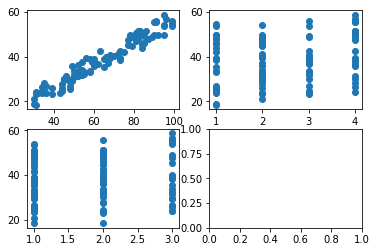

In [7]:
fig,axs = plt.subplots(2,2)
axs[0, 0].plot(x[:,0],y,'o')
axs[0, 1].plot(x[:,1],y,'o')
axs[1, 0].plot(x[:,2],y,'o')

Linear correlation can be evaluated through Pearson's coefficient, which returns a value between 0 and 1. 0 means there is no correlation, while 1 means perfect correlation. Everything in betweeen indicates that the data is somehow correlated, though usually a correlation of more than 0.8 is expected for a variable to be considered a predictor, i.e an input to a Machine Learning model.

In [8]:
# Check correlation of each input with the input
from scipy.stats import pearsonr
print(f'Correlation between x1 and y = {pearsonr(x[:,0],y[:,0])[0]:.2f}')
print(f'Correlation between x2 and y = {pearsonr(x[:,1],y[:,0])[0]:.2f}')
print(f'Correlation between x3 and y = {pearsonr(x[:,2],y[:,0])[0]:.2f}')

Correlation between x1 and y = 0.97
Correlation between x2 and y = 0.24
Correlation between x3 and y = 0.11


Results above shows that only the size shows high correlation with the price. Even though, we will keep the other variables as predictor, for the sake of this exercise of a multivariate linear regression.

Add a bias column to the input vector. This is a column of ones so when we calibrate the parameters it will also multiply such bias.

In [9]:
# Add a bias to the input vector
X = np.concatenate((np.ones((len(x),1)),x),axis=1)
X.shape

(99, 4)

Another important pre-processing is data normalization. In multivariate regression, the difference in the scale of each variable may cause difficulties for the optimization algorithm to converge, i.e to find the best optimum according the model structure. This procedure is also known as **Feature Scaling**.

In [10]:
Xnorm = X.copy()
minx = np.min(X[:,1:])
maxx = np.max(X[:,1:])
Xnorm[:,1:] = (X[:,1:]-minx)/(maxx-minx)
Xnorm[:10,:]

array([[1.        , 0.84693878, 0.        , 0.        ],
       [1.        , 0.44897959, 0.03061224, 0.        ],
       [1.        , 0.73469388, 0.        , 0.02040816],
       [1.        , 0.33673469, 0.01020408, 0.02040816],
       [1.        , 0.30612245, 0.03061224, 0.02040816],
       [1.        , 0.30612245, 0.02040816, 0.01020408],
       [1.        , 0.91836735, 0.03061224, 0.02040816],
       [1.        , 0.33673469, 0.02040816, 0.01020408],
       [1.        , 0.33673469, 0.03061224, 0.        ],
       [1.        , 0.79591837, 0.02040816, 0.02040816]])

In [11]:
ynorm = y.copy()
maxy = np.max(y)
miny = np.min(y)
ynorm = (y-miny)/(maxy - miny) 
ynorm[:10,0]

array([0.62943377, 0.28902469, 0.5230232 , 0.13457221, 0.14045897,
       0.11666251, 0.92968321, 0.15153405, 0.19299077, 0.75762035])

Now we are ready to start working on the model. It is reasonable to give an initial guess on the parameters and check this initial guess makes sense or is it complete nonsense. In this exercise, the choosen vector of parameters $\theta$ is 

$$
\theta = \begin{bmatrix}0.4 \\ 0.4 \\ 0.4 \\0.4 \end{bmatrix}
$$

Notice that there are 4 parameters, which corresponds to the bias + the input variables from the data. The linear regression model works according the following formula.

$$
Y = X\cdot \theta
$$

Thus, $X$ is the input matrix with dimension (99,4), while the vector $theta$ is a vector of $(4,1)$, thus the resultant matrix has dimension $(99,1)$, which  indicates that our calculation process is correct.


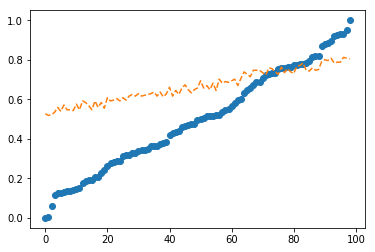

In [12]:
# Initial estimate of parameters
theta0 = np.zeros((X.shape[1],1))+0.4
#theta0 = np.array([[0],[0.5],[2],[0.5]])

ypred = Xnorm.dot(theta0)

sortidx = np.argsort(ynorm[:,0]) # sort the values for better visualization
plt.plot(ynorm[sortidx,0],'o')
plt.plot(ypred[sortidx,0],'--')

Create a function `grad()` to compute the necessary gradients of the cost function. This is explained with higher details in the other post I mentioned in the beginning of this one. But only to remember, the gradient can be calculated as:

$$
\frac{\partial J}{\partial \theta_j} = \frac{1}{m}\sum(f(\theta) - y)x_j
$$

Where $j=0,1,..,3$ since there are four predictors. This will produce a derivative for each input $j$, thus the complete gradient consists on the vector:

$$
\nabla J = [\frac{\partial J}{\partial \theta_0},...,\frac{\partial J}{\partial \theta_3}]
$$

In [0]:
# calculate gradient
def grad(theta):
    dJ = 1/m*np.sum((Xnorm.dot(theta)-ynorm)*Xnorm,axis=0).reshape(-1,1)
    return dJ

In [14]:
grad(theta0)

array([[0.16830492],
       [0.0739841 ],
       [0.00197455],
       [0.00134667]])

Similarly, calculate the cost function, also known as objective function, which can be expressed as the sum of the squared errors, as follows.

$$
J = \sum(f(\theta)-y)^2
$$

In [0]:
def cost(theta):
    J = np.sum((Xnorm.dot(theta)-ynorm)**2,axis=0)[0]
    return J

In [16]:
cost(theta0)

5.923489427685076

We are ready to implement the Gradient Descent algorithm! The steps of this algorithm consists of:
- Obtain the gradients of the cost function according the actual value of the parameters;
- Calculate the cost to keep track of it;
- Update the parameters according the following schedule:

$$
\theta^{i+1} = \theta^i - \alpha\times\nabla J(\theta^i)
$$

Where the superscript $i$ refers to the current iteration. Then the iterative steps are repeated until the algorithm converges.

In [0]:
def GD(theta0,learning_rate = 0.5,epochs=1000,TOL=1e-7):
    
    theta_history = [theta0]
    J_history = [cost(theta0)]
    
    thetanew = theta0*10000
    print(f'epoch \t Cost(J) \t')
    for epoch in range(epochs):
        if epoch%100 == 0:
            print(f'{epoch:5d}\t{J_history[-1]:7.4f}\t')
        dJ = grad(theta0)
        J = cost(theta0)
        
        thetanew = theta0 - learning_rate*dJ
        theta_history.append(thetanew)
        J_history.append(J)
        
        if np.sum((thetanew - theta0)**2) < TOL:
            print('Convergence achieved.')
            break
        theta0 = thetanew

    return thetanew,theta_history,J_history
           
            
        

In the above code, a maximum number of iterations is fixed. This avoid the algorithm to loop infinitely. Additionally, the iteration process is stopped if the following criteria is met at any point.

$$
\sum(\theta^{i+1}-\theta^{i})^2 < \text{TOL}
$$

Where TOL is a tolerance, i.e a maximum difference between the values of the parameters between iterations so it can be stated that the values converged.

Next, evaluate the Gradient Descent to determine the optimum set of parameters for the linear regression.

In [18]:
theta,theta_history,J_history = GD(theta0)

epoch 	 Cost(J) 	
    0	 5.9235	
  100	 0.5097	
  200	 0.3353	
  300	 0.3226	
Convergence achieved.


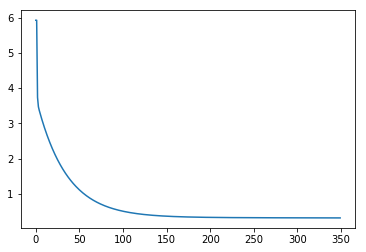

In [19]:
plt.plot(J_history)

Observe in the plot above how the cost function J drastically reduces at the initial iterations, converging to a value much smaller than the initial one. By using an appropriate Tolerance TOL, the iteration process was halted at less than 350 iterations, though the maximum number was initially fixed to 1000.

We can perform predictions on the training set using the following code.

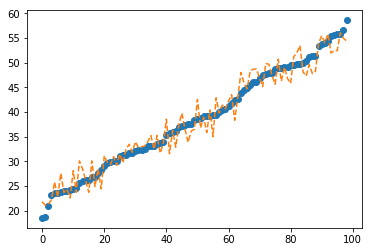

In [20]:
yprednorm = Xnorm.dot(theta)

ypred = yprednorm*(maxy-miny) + miny
plt.plot(y[sortidx,0],'o')
plt.plot(ypred[sortidx,0],'--')

The following function is to used to get an input, normalize it, perform predictions using the values of $\theta$ encountered, and denormalizing the output to come back to the original range.

In [0]:
def predict(x,theta):
    xnorm = (x-minx)/(maxx-minx)
    yprednorm = xnorm.dot(theta)
    ypred = yprednorm*(maxy - miny) + miny
    return ypred

Let's use our model to predict the price of a house with 73 square meters, 1 bedroom and 1 bathroom.

In [22]:
x = np.array([1,73,1,1])

predict(x,theta)

array([54.35879773])

To confirm that the model is statistically significant, use the Pearson correlation and evaluate the predicted output against the observed one.

In [23]:
pearsonr(ypred.reshape(-1),y.reshape(-1))

(0.9753195824331272, 1.930066280643269e-65)

Notice here that the value of pearson correlation is 0.97 which indicates high correlation.
The second value (1.93e-65) is the p-value. It must be a very low value for us to reject the null hypothesis, i,e there is no initial hypothesis of linear correlation. Assuming 1% significance level, we have:
0.01 >> 1.93e-65 thus we can reject the null hypothesis thus indicating linear correlation between the prediction and observations.

See you next post!